In [212]:
import requests
import io
import pandas as pd
import numpy as np
import json
import datetime
import time
# from sqlalchemy import create_engine
import psycopg2 
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [5]:
def reorderdate(s):
    list_str = [s[4:6],s[0:2],s[2:4]]
    new_str = '-'.join(list_str)
    return new_str

In [634]:
conn = psycopg2.connect( host=hostname, user=username, password=password, dbname=database )
# sql_cmd = "select * from tos_chain"
sql_cmd = "select * from tos_chain where date>='2023-09-08'"
data0 = pd.read_sql(sql_cmd, conn)
conn.close()

C:\Users\geng\AppData\Local\Temp\ipykernel_12688\2135624475.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data0 = pd.read_sql(sql_cmd, conn)


In [635]:
data0 = data0[data0['sym']!='SPX']

In [636]:
# csv data
data0.shape

(583380, 57)

In [639]:
# df = data0[data0['sym'].isin(['SPXW'])]
df = data0.copy()

In [641]:
res = df.resample('30Min', label='right', closed='right', on='timestamp').last()

In [643]:
df = df[df['time'].isin(res['time'])]

In [644]:
df['time'].value_counts().sort_index()

07:59:37    9260
08:25:10    9260
08:55:51    9260
09:26:32    9260
09:57:13    9260
10:27:54    9260
10:58:34    9260
11:29:16    9260
11:59:57    9260
12:25:31    9260
12:56:13    9260
13:01:20    9260
Name: time, dtype: int64

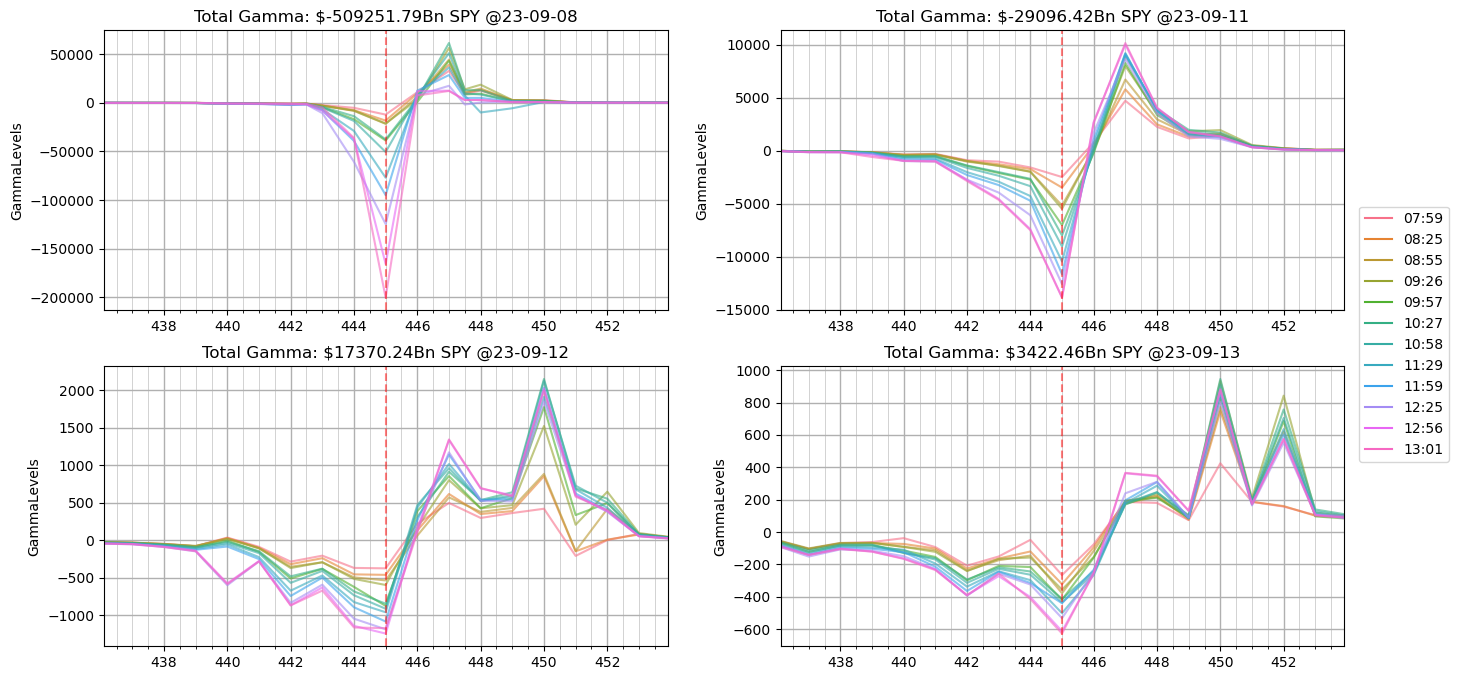

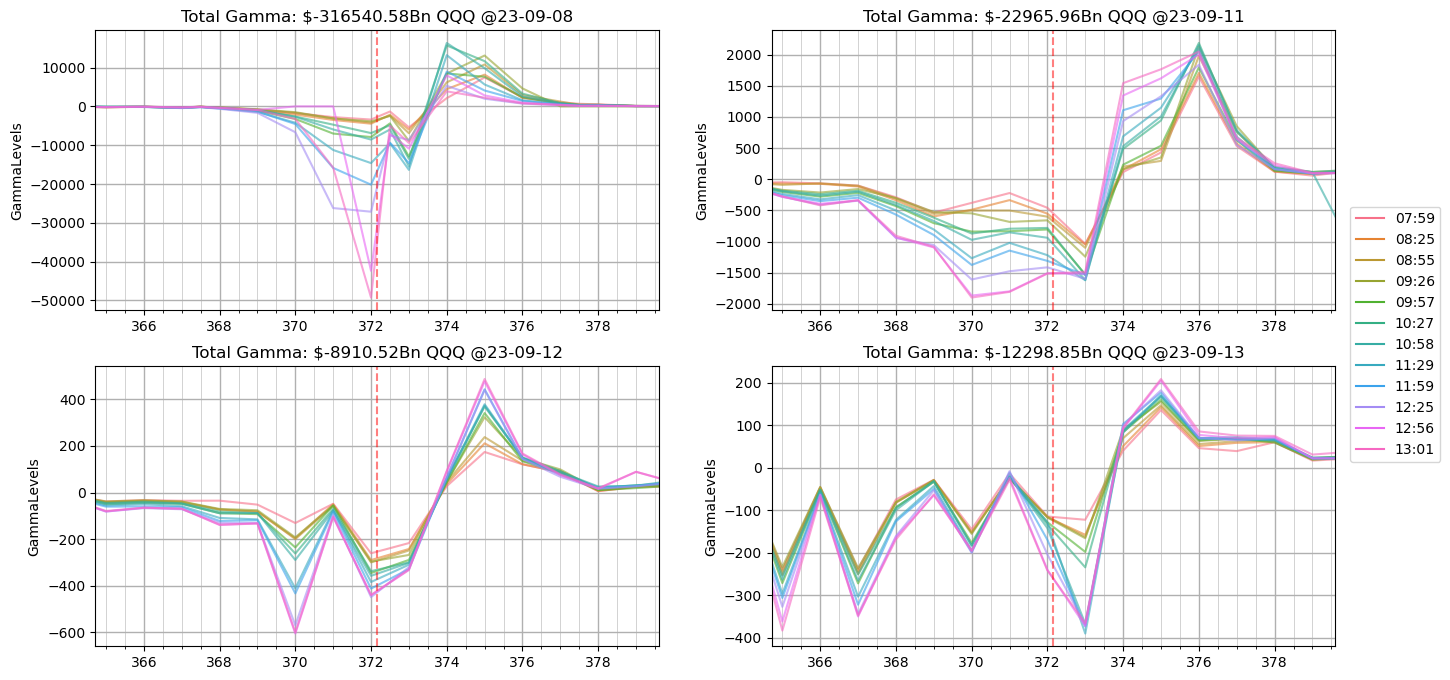

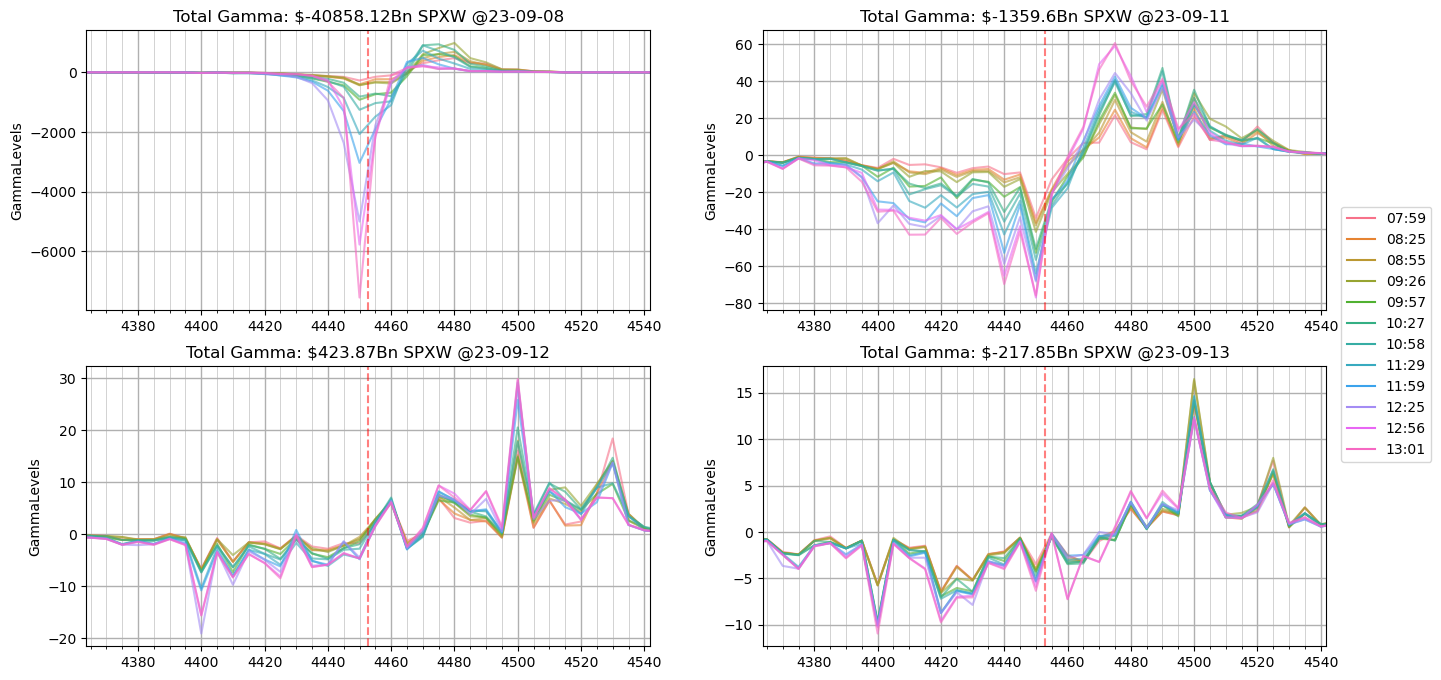

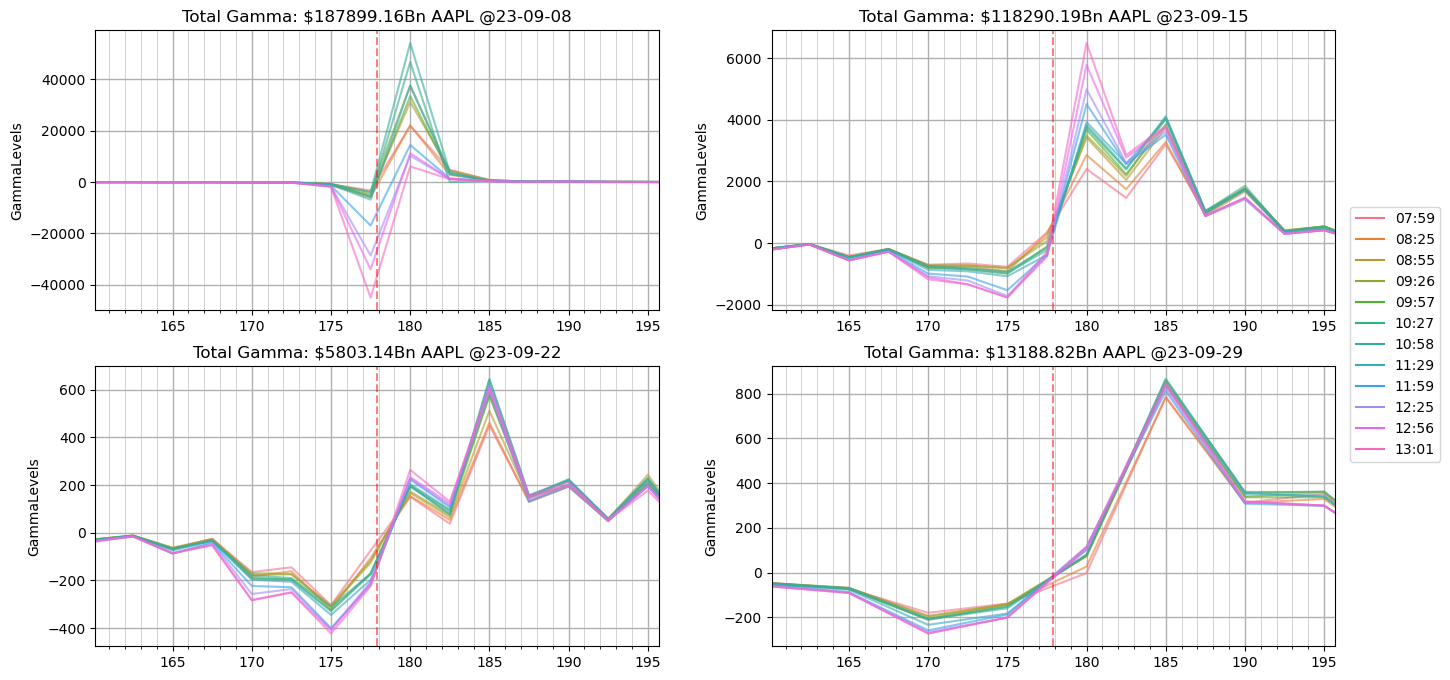

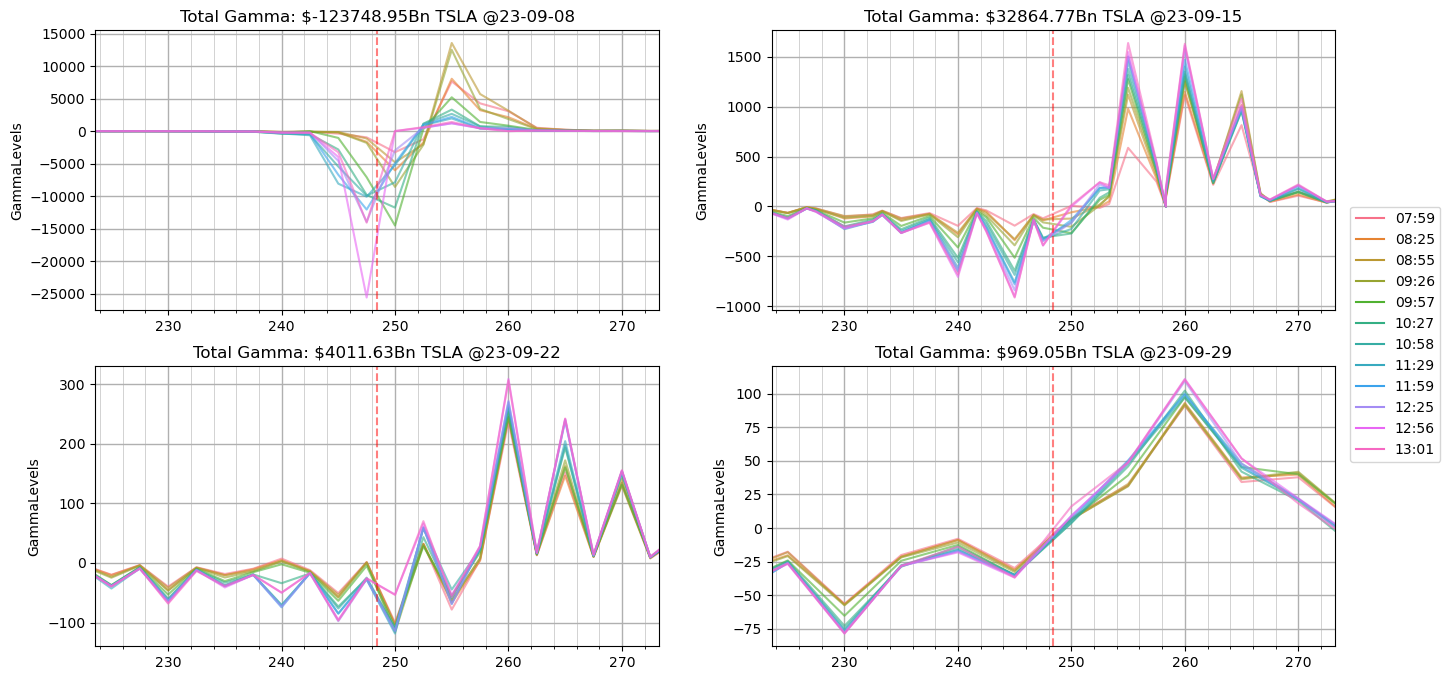

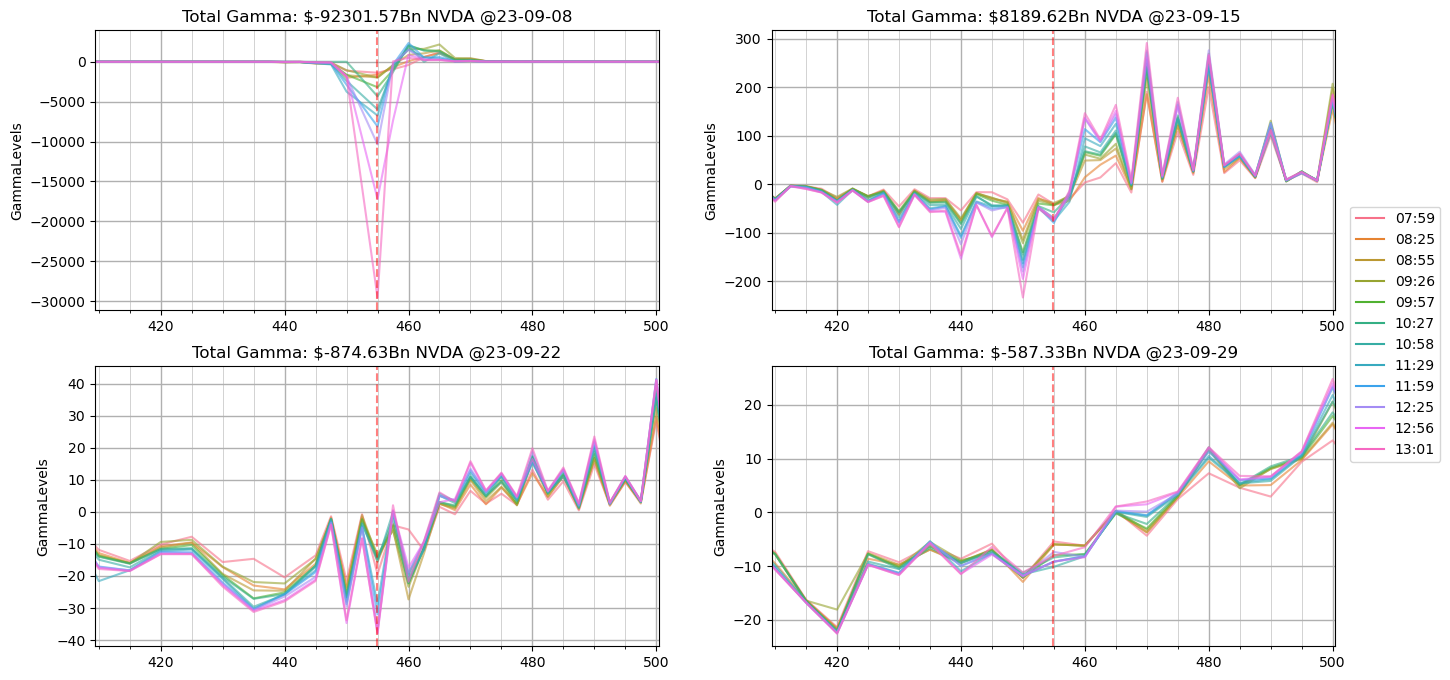

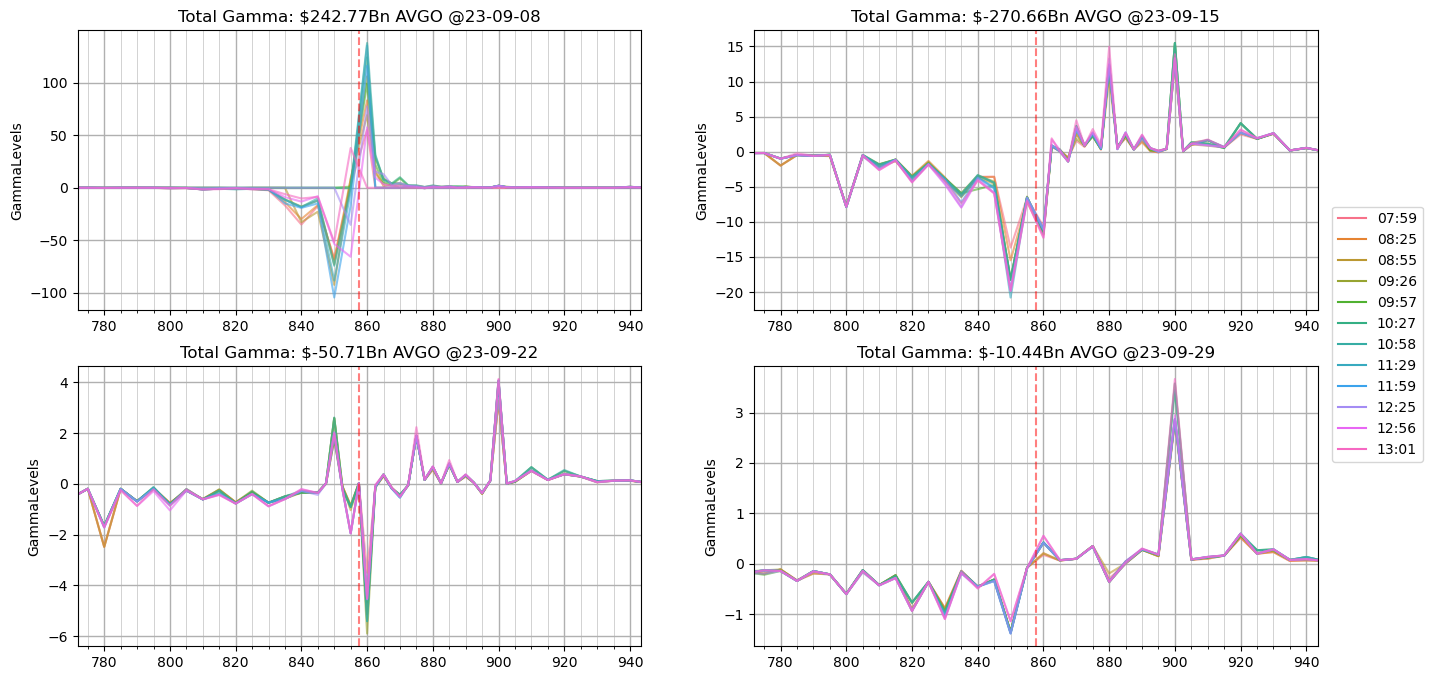

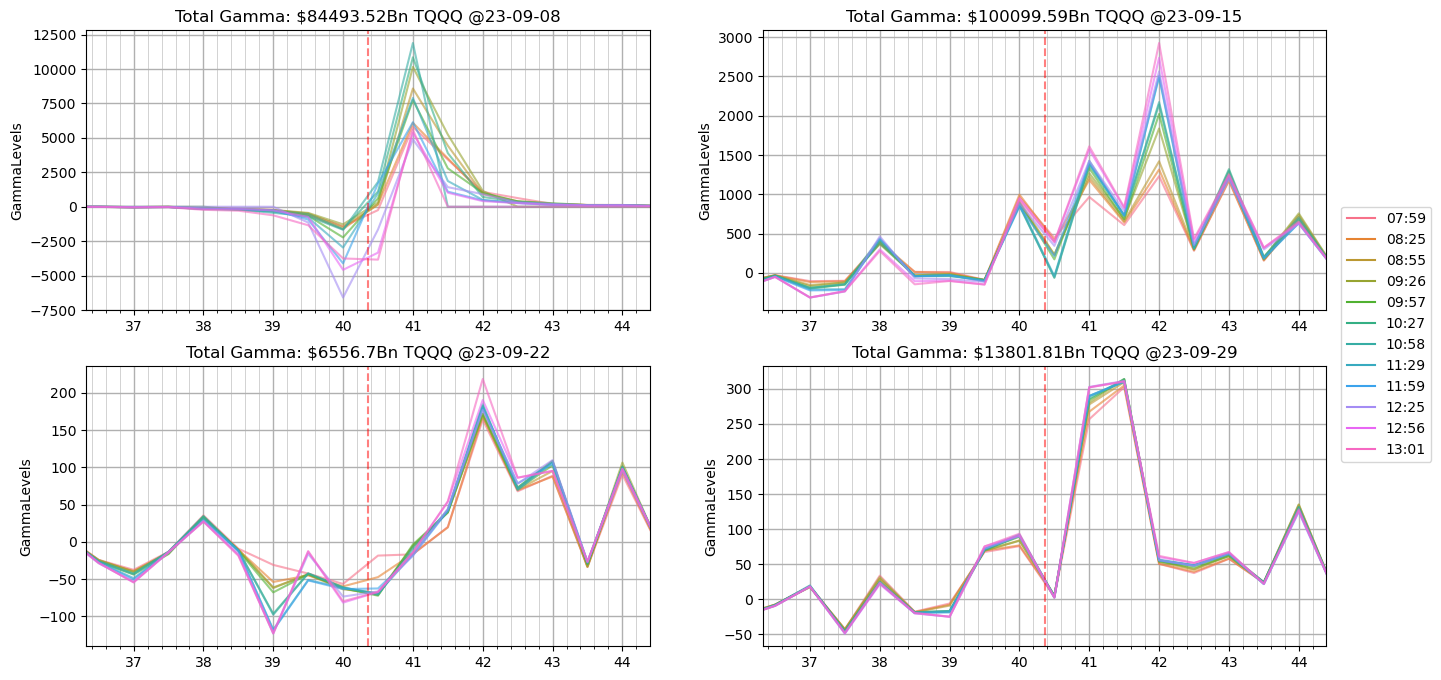

In [645]:
# sym_list = ['SPXW','SPY','QQQ']
for s in df['sym'].unique():
# for s in sym_list:
    df1 = df.loc[df['sym']==s].copy()
    df1['expdate1'] = df1['expdate'].apply(reorderdate)
    sel = df1.groupby(['sym'])['expdate1'].unique()
    df1 = df1[df1['expdate1'].isin(sel[s][:4])]
    df1.sort_values('time', inplace=True)
    price = df1['price'].iloc[-1]
    
    df1['sign'] = df1.apply(lambda row: 1 if row.putcall=='CALL' else -1, axis=1)
    df1['gex'] = df1['gamma'] * (df1['totalvolume'] + df1['openinterest']) * df1['sign']
    
    df1['tm'] = df1.apply(lambda row: str(row.time)[0:5], axis=1)       
    n = df1['tm'].nunique()
    
    gex = df1.groupby(['sym','expdate1','strike','tm'],as_index=False)['gex'].sum()
    tg = df1.groupby(['sym','expdate1'])['gex'].sum()
    tg = round(tg,2)
    
    if s == 'SPXW' or s == 'SPY' or s == 'QQQ':
        pct = 0.02
    else:
        pct = 0.1

    fig, ax = plt.subplots(2,2,figsize=(16,8))
    ax = ax.flatten()
    i = 0
    for expd in gex['expdate1'].unique():
        dp = gex.loc[(gex['expdate1']==expd),:]
        sns.lineplot(x='strike',y='gex',hue='tm',data=dp,alpha=0.6,ax=ax[i])
    
        ax[i].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#         ax[i].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        ax[i].grid(which='major', linewidth=1.0)
        ax[i].grid(which='minor', linewidth=0.5, alpha=0.8)       
        
        ax[i].set(xlim=(price*(1-pct), price*(1+pct)))
#         ax[i].title.set_text('Total Gamma: $'+str(tg[i])+'Bn per 1% '+s+'_'+str(i+1)+' Move @'+expd)
        ax[i].title.set_text('Total Gamma: $'+str(tg[i])+'Bn '+s+' '+'@'+expd)
    #     ax[i].title.set_size(10)
        ax[i].set_xlabel('')
        ax[i].set_ylabel('GammaLevels')
        ax[i].axvline(price, ls='--', c='red', alpha=0.5)
#         ax[i].legend(fontsize=6)
#         ax[i].legend(loc='lower right')
        ax[i].get_legend().remove()       
        i += 1
        
    lines_labels = [fig.axes[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = 'right', bbox_to_anchor = (0, 0, 0.97, 1),
           bbox_transform = plt.gcf().transFigure)
    # fig.tight_layout()        

In [519]:
df1

,putcall,symbol,description,exchangename,bid,ask,last,mark,bidsize,asksize,...,mini,nonstandard,timestamp,sym,expd_strk,expdate,strike,date,time,price
18713,CALL,SPY_090723C360,SPY Sep 7 2023 360 Call (Weekly),OPR,84.91,85.06,84.90,84.99,100,100,...,True,False,2023-09-07 10:55:19,SPY,090723_360,090723,360.0,2023-09-07,10:55:19,445.01
18714,CALL,SPY_090723C370,SPY Sep 7 2023 370 Call (Weekly),OPR,74.92,75.06,73.30,74.99,100,100,...,True,False,2023-09-07 10:55:19,SPY,090723_370,090723,370.0,2023-09-07,10:55:19,445.01
18715,CALL,SPY_090723C374,SPY Sep 7 2023 374 Call (Weekly),OPR,70.92,71.06,0.00,70.99,100,100,...,True,False,2023-09-07 10:55:19,SPY,090723_374,090723,374.0,2023-09-07,10:55:19,445.01
18716,CALL,SPY_090723C375,SPY Sep 7 2023 375 Call (Weekly),OPR,69.91,70.07,70.13,69.99,100,100,...,True,False,2023-09-07 10:55:19,SPY,090723_375,090723,375.0,2023-09-07,10:55:19,445.01
18717,CALL,SPY_090723C376,SPY Sep 7 2023 376 Call (Weekly),OPR,68.91,69.07,68.25,68.99,100,100,...,True,False,2023-09-07 10:55:19,SPY,090723_376,090723,376.0,2023-09-07,10:55:19,445.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233826,PUT,SPXW_091223P5000,SPXW Sep 12 2023 5000 Put (PM),OPR,545.10,548.80,0.00,546.95,94,37,...,False,True,2023-09-07 13:02:54,SPXW,091223_5000,091223,5000.0,2023-09-07,13:02:54,4450.27
233827,PUT,SPXW_091223P5200,SPXW Sep 12 2023 5200 Put (PM),OPR,744.70,748.70,0.00,746.70,118,50,...,False,True,2023-09-07 13:02:54,SPXW,091223_5200,091223,5200.0,2023-09-07,13:02:54,4450.27
233828,PUT,SPXW_091223P5400,SPXW Sep 12 2023 5400 Put (PM),OPR,944.80,948.50,0.00,946.65,83,50,...,False,True,2023-09-07 13:02:54,SPXW,091223_5400,091223,5400.0,2023-09-07,13:02:54,4450.27
233829,PUT,SPXW_091223P5600,SPXW Sep 12 2023 5600 Put (PM),OPR,1144.70,1148.40,0.00,1146.55,54,50,...,False,True,2023-09-07 13:02:54,SPXW,091223_5600,091223,5600.0,2023-09-07,13:02:54,4450.27
